In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
#import sklearn
from sklearn.preprocessing import normalize
from scipy import stats
import matplotlib.pyplot as plt

/home/mperf/anaconda3/envs/myenv/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/google: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/home/mperf/anaconda3/envs/myenv/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _ins

# Load features and labels

In [2]:
feature_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/features.npy'
label_path = '../data/03996723-2411-4167-b14b-eb11dfc33124/labels.npy'
features = np.load(feature_path)
labels = stats.mode(np.load(label_path), axis=1)[0][:, 0]

print('Feature matrix shape:', features.shape)
print('Label matrix shape:', labels.shape)

Feature matrix shape: (128699, 170)
Label matrix shape: (128699,)


In [3]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 99967, 1.0: 28732}


In [4]:
zero_indices = np.where(labels==0)[0]
one_indices = np.where(labels==1)[0]
print(zero_indices.shape)
inds = np.random.randint(low=0, high=99967, size=28732)

zero_indices = zero_indices[inds]

indices = np.hstack((zero_indices, one_indices))

np.random.shuffle(indices)

new_labels = labels[indices]
new_features = features[indices]


(99967,)


In [5]:
num_classes = 2
split_idx = int(new_features.shape[0] * 0.75)

#X_train = normalize(new_features[:split_idx])
X_train = new_features[:split_idx]
Y_train = new_labels[:split_idx]

#X_val = normalize(new_features[split_idx:])
X_val = new_features[split_idx:]
Y_val = new_labels[split_idx:]

Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_val = keras.utils.to_categorical(Y_val, num_classes)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(43098, 170)
(43098, 2)
(14366, 170)
(14366, 2)


# Create MLP classifier

In [20]:
p = 0.3
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(units=128, activation='relu', input_dim=features.shape[1]))
# Add another:
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dropout(p))
model.add(keras.layers.Dense(units=32, activation='relu'))

# Add a softmax layer with 10 output units:
model.add(keras.layers.Dense(units=2, activation='softmax'))

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               21888     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 32,290
Trainable params: 32,290
Non-trainable params: 0
_________________________________________________________________


In [22]:
epochs = 60
batch_size = 512
data_path = '.'
data_file = '/DNN_Model-10Second'


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


checkpointer = keras.callbacks.ModelCheckpoint(filepath=data_path+data_file, 
                                               verbose=1,
                                               monitor='val_acc',
                                               save_best_only=True, 
                                               save_weights_only=False)
# checkpoint
# filepath="weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpointer]

H = model.fit(X_train, 
              Y_train, 
              batch_size=batch_size, 
              epochs=epochs, verbose=1, 
              shuffle=True, 
              validation_data=(X_val, Y_val), 
              callbacks=callbacks_list)

/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Train on 43098 samples, validate on 14366 samples
Epoch 1/60
43098/43098 [==============================] - 1s 20us/step - loss: 7.9106 - acc: 0.5091 - val_loss: 8.0445 - val_acc: 0.5009

Epoch 00001: val_acc improved from -inf to 0.50090, saving model to ./DNN_Model-10Second
Epoch 2/60
43098/43098 [==============================] - 0s 8us/step - loss: 7.9711 - acc: 0.5054 - val_loss: 8.0307 - val_acc: 0.5017

Epoch 00002: val_acc improved from 0.50090 to 0.50167, saving model to ./DNN_Model-10Second
Epoch 3/60
43098/43098 [==============================] - 0s 7us/step - loss: 8.3653 - acc: 0.4807 - val_loss: 8.3003 - val_acc: 0.4850

Epoch 00003: val_acc did not improve from 0.50167
Epoch 4/60
43098/43098 [==============================] - 0s 7us/step - loss: 8.1316 - acc: 0.4954 - val_loss: 8.0355 - val_acc: 0.5015

Epoch 00004: val_acc did not improve from 0.50167
Epoch 5/60
43098/43098 [==============================] - 0s 7us/step - loss: 8.0758 - acc: 0.4989 - val_loss: 8.0355 - 


Epoch 00043: val_acc did not improve from 0.59954
Epoch 44/60
43098/43098 [==============================] - 0s 7us/step - loss: 8.0669 - acc: 0.4995 - val_loss: 8.0355 - val_acc: 0.5015

Epoch 00044: val_acc did not improve from 0.59954
Epoch 45/60
43098/43098 [==============================] - 0s 7us/step - loss: 8.0669 - acc: 0.4995 - val_loss: 8.0355 - val_acc: 0.5015

Epoch 00045: val_acc did not improve from 0.59954
Epoch 46/60
43098/43098 [==============================] - 0s 7us/step - loss: 8.0680 - acc: 0.4994 - val_loss: 8.0355 - val_acc: 0.5015

Epoch 00046: val_acc did not improve from 0.59954
Epoch 47/60
43098/43098 [==============================] - 0s 7us/step - loss: 8.0669 - acc: 0.4995 - val_loss: 8.0355 - val_acc: 0.5015

Epoch 00047: val_acc did not improve from 0.59954
Epoch 48/60
43098/43098 [==============================] - 0s 7us/step - loss: 8.0706 - acc: 0.4993 - val_loss: 8.0355 - val_acc: 0.5015

Epoch 00048: val_acc did not improve from 0.59954
Epoch 49/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


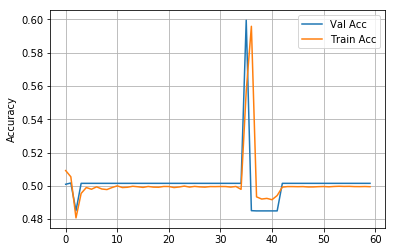

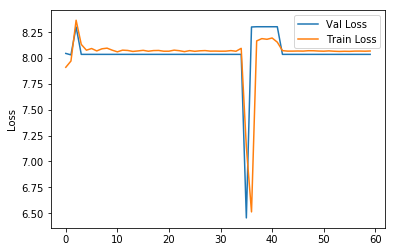

In [23]:
print(H.history.keys())

val_acc=H.history['val_acc']
acc = H.history['acc']

val_loss=H.history['val_loss']
loss = H.history['loss']


#fig= plt.figure(figsize=(15,10))
plt.plot(val_acc,label='Val Acc')
plt.plot(acc,label='Train Acc')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


#fig= plt.figure(figsize=(15,10))
plt.plot(val_loss,label='Val Loss')
plt.plot(loss,label='Train Loss')

plt.ylabel('Loss')
plt.legend()
plt.show()